In [1]:
%matplotlib inline
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps, ImageFilter
from scipy.ndimage.filters import laplace, generic_filter
from scipy.ndimage import (gaussian_gradient_magnitude, sobel,
                           maximum_filter, gaussian_laplace)

from dataset_utils import load_img, img_to_dataset, grid_plot, get_training_windows

from tensorflow import keras as K
import tensorflow as tf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## loading the data

In [4]:
data_source = '../../data/antibodies/DL-dataset/masked/'
glob.glob(data_source + '*')

['../../data/antibodies/DL-dataset/masked/NUC',
 '../../data/antibodies/DL-dataset/masked/ACA',
 '../../data/antibodies/DL-dataset/masked/ZIA',
 '../../data/antibodies/DL-dataset/masked/HOM']

In [5]:
class_files = {}
for name in ['NUC', 'ACA', 'ZIA', 'HOM']:
    files = list(sorted(glob.glob(f'{data_source}/{name}/*')))
    class_files[name] = files

In [6]:
class_indices = {
    'NUC': 0,
    'ACA': 1,
    'ZIA': 2,
    'HOM': 3
}

masked_data = {}

for name, files in class_files.items():
    class_index = class_indices[name]
    imgs = [load_img(f, grayscale=True) for i, f in enumerate(files) if i % 2 == 1]
    masks = [load_img(f, grayscale=True) for i, f in enumerate(files) if i % 2 == 0]
    masked_data[name] = []
    
    for img, mask in zip(imgs, masks):
        masked_data[name].append((img, mask, class_index))

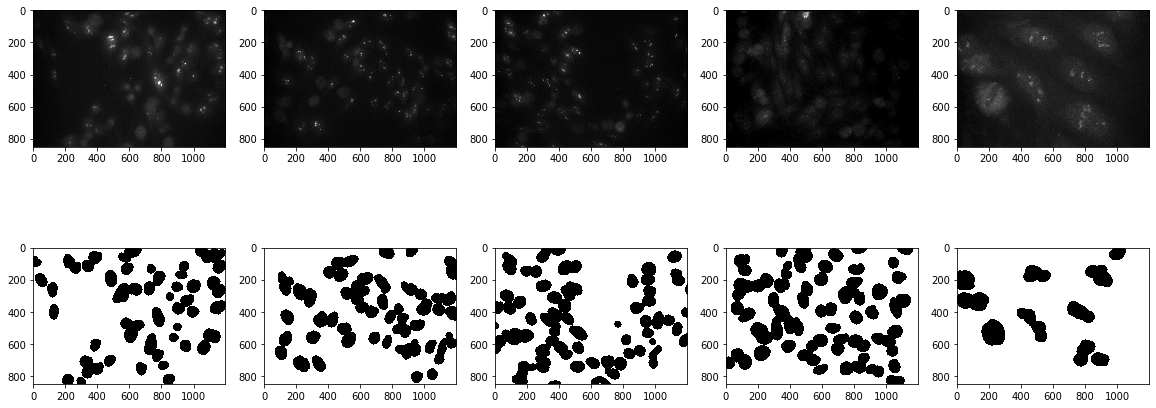

In [7]:
sample_imgs = [masked_data['NUC'][i][0] for i in range(5)]
sample_masks = [masked_data['NUC'][i][1] for i in range(5)]

plt.figure(figsize=(20, 8))
grid_plot(sample_imgs + sample_masks, cmap='gray', rows=2, cols=5)

## defining datasets

In [8]:
def extract_meaningful_crops(img, mask, crop_size, crop_stride, mask_fill_threshold):
    
    bin_mask = mask < 100
    _, pos = get_training_windows(img, bin_mask, 
                                  pos_threshold=mask_fill_threshold, neg_threshold=1,
                                  window_size=crop_size, stride=crop_stride)
    
    return pos

def get_dataset_from_records(masked_records, crop_size, crop_stride, mask_fill_threshold):
    
    X = []
    y = []
    
    for record in masked_records:
        img, mask, class_index = record
        crops = extract_meaningful_crops(img, mask, crop_size, crop_stride, mask_fill_threshold)
        
        X.append(crops)
        y.append(np.full(crops.shape[0], fill_value=class_index))
        
    X = np.concatenate(X)
    y = np.concatenate(y)
    
    return X, y

def get_dataset(masked_data, train_samples, test_samples, crop_size, crop_stride, mask_fill_threshold):
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for name, data in masked_data.items():
        
        train_count = 0
        test_count = 0
        
        tmp_X_train = []
        tmp_y_train = []
        tmp_X_test = []
        tmp_y_test = []
        
        for record in data:
            X, y = get_dataset_from_records([record], crop_size, crop_stride, mask_fill_threshold)
            
            if train_count < train_samples:
                train_count += X.shape[0]
                tmp_X_train.append(X)
                tmp_y_train.append(y)
                
            elif test_count < test_samples:
                test_count += X.shape[0]
                tmp_X_test.append(X),
                tmp_y_test.append(y)
                
        tmp_X_train = np.concatenate(tmp_X_train)
        tmp_y_train = np.concatenate(tmp_y_train)
        tmp_X_test = np.concatenate(tmp_X_test)
        tmp_y_test = np.concatenate(tmp_y_test)
                
        X_train.append(tmp_X_train[:train_samples])
        y_train.append(tmp_y_train[:train_samples])
        X_test.append(tmp_X_test[:test_samples])
        y_test.append(tmp_y_test[:test_samples])
        print(f'finished {name}, train samples: {train_count}, test_samples: {test_count}')
                
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)
                
    return X_train, y_train, X_test, y_test

In [9]:
%%time
dataset = get_dataset(masked_data, train_samples=2000, test_samples=500,
                      crop_size=128, crop_stride=16, mask_fill_threshold=0.6)

finished NUC, train samples: 2239, test_samples: 840
finished ACA, train samples: 2135, test_samples: 739
finished ZIA, train samples: 2498, test_samples: 548
finished HOM, train samples: 2193, test_samples: 689
CPU times: user 15 s, sys: 26.1 s, total: 41.1 s
Wall time: 41.1 s


In [10]:
X_train, y_train, X_test, y_test = dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8000, 128, 128) (8000,) (2000, 128, 128) (2000,)


## network training

In [11]:
from tensorflow.keras.applications import resnet_v2, inception_v3

In [12]:
# input_tensor = K.layers.Input(shape=(128, 128, 3))
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [13]:
model_top = K.layers.Conv2D(4, 2, activation='softmax')(base_model.output)
# model_top = K.layers.Dense(4, activation='softmax')(model_top)

In [24]:
full_model = K.Model(base_model.input, model_top, name='cells-transfer')
full_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
full_model.summary()

Model: "cells-transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [45]:
def prepare_X(X, expand_dims=False):
    X_prep = X.copy()
    X_prep = X_prep.astype(np.float32)
    
    if expand_dims:
        X_prep = tf.expand_dims(X_prep, axis=0)
    
    X_prep = tf.expand_dims(X_prep, axis=-1)
    X_prep = tf.repeat(X_prep, 3, axis=-1)
    X_prep = tf.map_fn(inception_v3.preprocess_input, X_prep)
        
    return X_prep

def prepare_y(y, depth=None):
    
    if depth is not None:
        y = tf.one_hot(y, depth=depth)
    
    return tf.reshape(y, (-1, 1, 1, y.shape[-1]))

In [22]:
%%time

X_train_prep = prepare_X(X_train)
y_train_prep = prepare_y(y_train, depth=4)

X_test_prep = prepare_X(X_test)
y_test_prep = prepare_y(y_test, depth=4)

CPU times: user 6.4 s, sys: 1.38 s, total: 7.78 s
Wall time: 7.06 s


In [23]:
X_train_prep.shape

TensorShape([8000, 128, 128, 3])

In [59]:
# run after pretraining

base_model.trainable = True
full_model.compile(optimizer=K.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy', metrics=['accuracy'])

full_model.summary()

Model: "cells-transfer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_____________________________________________________________________________________

In [25]:
history = full_model.fit(
    X_train_prep, y_train_prep,
    epochs=10,
    batch_size=256,
    validation_data=(X_test_prep, y_test_prep)
)

Epoch 1/10
32/32 [==============================] - 14s 427ms/step - loss: 1.1296 - accuracy: 0.7427 - val_loss: 0.3220 - val_accuracy: 0.8905
Epoch 2/10
32/32 [==============================] - 10s 298ms/step - loss: 0.1970 - accuracy: 0.9336 - val_loss: 0.2858 - val_accuracy: 0.8945
Epoch 3/10
32/32 [==============================] - 9s 294ms/step - loss: 0.1127 - accuracy: 0.9616 - val_loss: 0.2597 - val_accuracy: 0.9050
Epoch 4/10
32/32 [==============================] - 9s 293ms/step - loss: 0.0824 - accuracy: 0.9741 - val_loss: 0.2495 - val_accuracy: 0.9125
Epoch 5/10
32/32 [==============================] - 9s 295ms/step - loss: 0.0643 - accuracy: 0.9822 - val_loss: 0.2316 - val_accuracy: 0.9165
Epoch 6/10
32/32 [==============================] - 9s 293ms/step - loss: 0.0510 - accuracy: 0.9874 - val_loss: 0.2227 - val_accuracy: 0.9205
Epoch 7/10
32/32 [==============================] - 9s 291ms/step - loss: 0.0419 - accuracy: 0.9911 - val_loss: 0.2298 - val_accuracy: 0.9215
Epoc

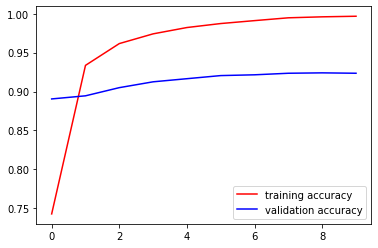

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# acc = np.concatenate([acc, history.history['accuracy']])
# val_acc = np.concatenate([val_acc, history.history['val_accuracy']])

plt.plot(acc, c='red', label='training accuracy')
plt.plot(val_acc, c='blue', label='validation accuracy')
plt.legend()

### heatmap visualization

In [42]:
test_img = masked_data['NUC'][-1][0]
test_img_mask = masked_data['NUC'][-1][1]
test_img_prep = np.expand_dims(test_img, axis=0)
test_img_prep = prepare_X(test_img_prep)

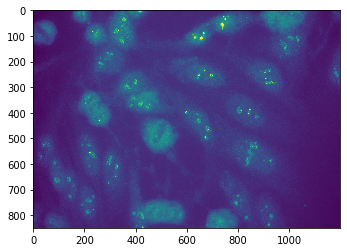

In [30]:
plt.imshow(test_img)

In [35]:
%%time
test_pred = full_model.predict(test_img_prep)[0]

CPU times: user 133 ms, sys: 34.5 ms, total: 168 ms
Wall time: 161 ms


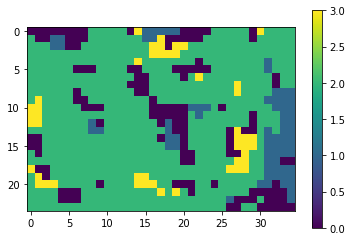

In [39]:
test_pred_classes = np.argmax(test_pred, axis=-1)
plt.imshow(test_pred_classes)
plt.colorbar()

In [41]:
class_indices

{'NUC': 0, 'ACA': 1, 'ZIA': 2, 'HOM': 3}

In [44]:
test_img_crops = extract_meaningful_crops(test_img, test_img_mask,
                                          crop_size=128, crop_stride=16, mask_fill_threshold=0.6)

test_img_crops.shape

(648, 128, 128)

In [46]:
test_crops_prep = prepare_X(test_img_crops)
test_crops_prep.shape

TensorShape([648, 128, 128, 3])

In [47]:
%%time
crops_pred = full_model.predict(test_crops_prep)

CPU times: user 3.07 s, sys: 587 ms, total: 3.65 s
Wall time: 3.43 s


In [50]:
crops_pred_classes = np.argmax(crops_pred, axis=-1)
crops_pred_classes = crops_pred_classes.reshape(-1)
crops_pred_classes.shape

(648,)

(array([351.,   0.,   0.,  32.,   0.,   0., 263.,   0.,   0.,   2.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

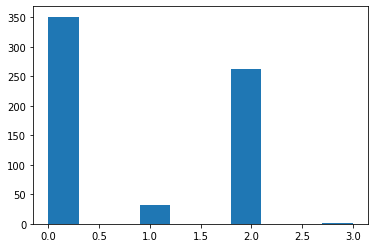

In [51]:
plt.hist(crops_pred_classes)

In [53]:
print(np.unique(crops_pred_classes, return_counts=True))
print(np.unique(test_pred_classes, return_counts=True))

(array([0, 1, 2, 3]), array([351,  32, 263,   2]))
(array([0, 1, 2, 3]), array([130,  72, 591,  47]))
